In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset as open_ncfile
import sys
sys.path.append('/home/ysilvy/Density_bining/Yona_analysis/programs/')
from maps_matplot_lib import zonal_2D, defVarmme, custom_div_cmap, modelagree
from modelsDef import defModels
import glob
import xarray as xr
import string
letters = string.ascii_lowercase
from libToE import ToEdomainrcp85vshistNat

CanESM2


/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CCSM4
CESM1-CAM5
CSIRO-Mk3-6-0
FGOALS-g2
GISS-E2-R
HadGEM2-ES
IPSL-CM5A-LR
IPSL-CM5A-MR
MIROC-ESM-CHEM
MIROC-ESM


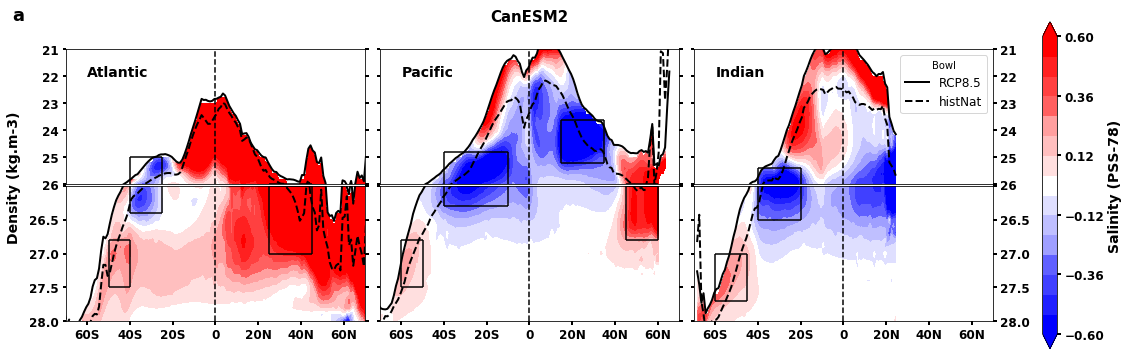

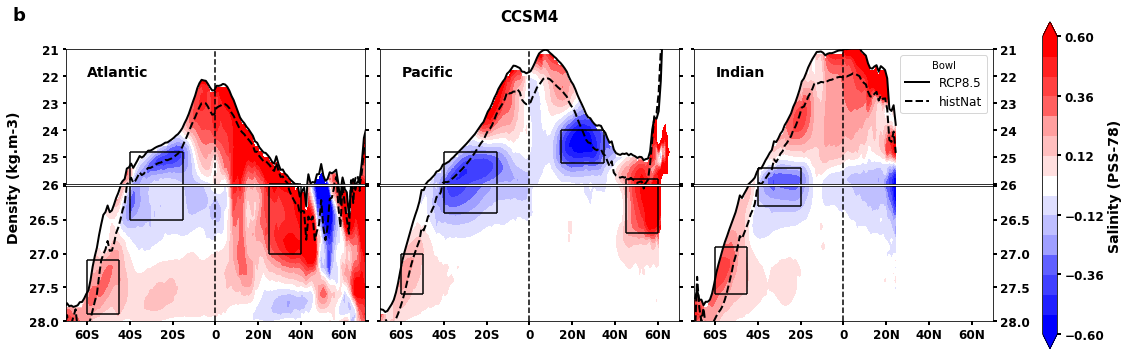

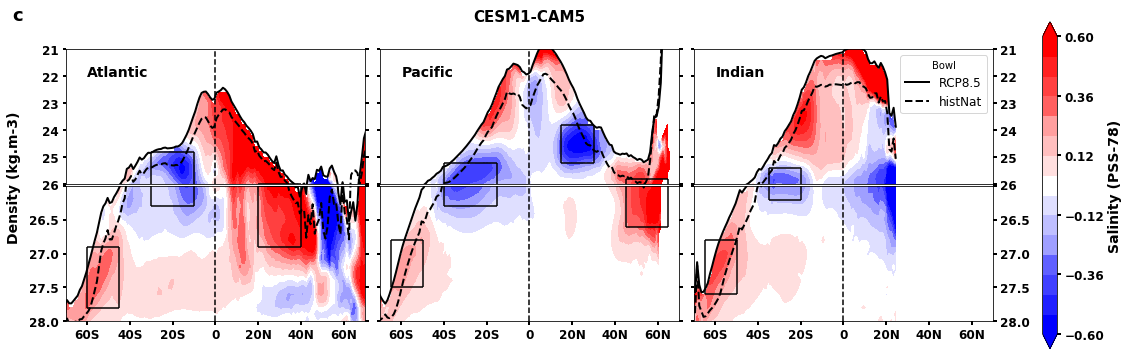

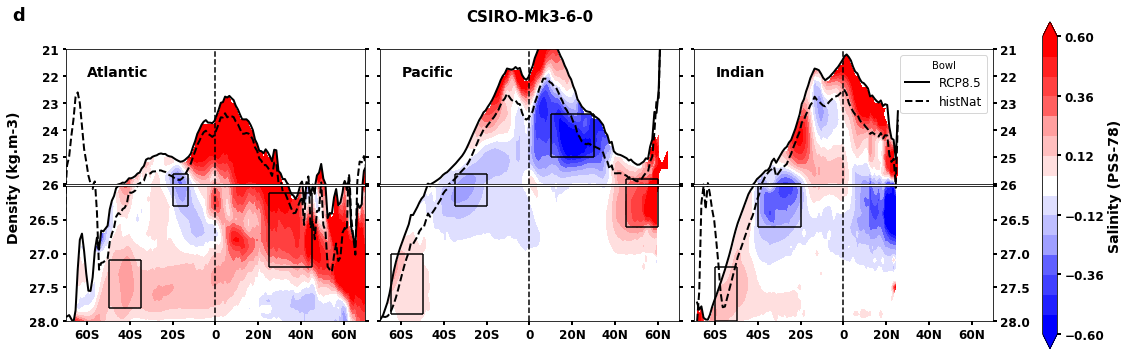

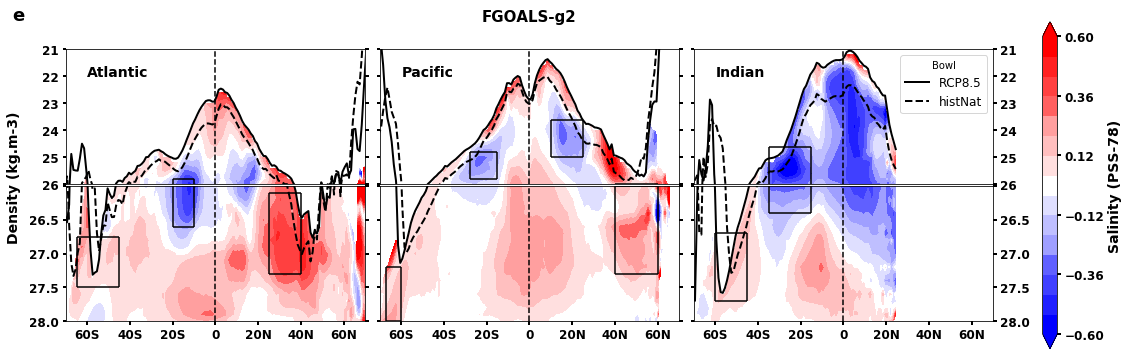

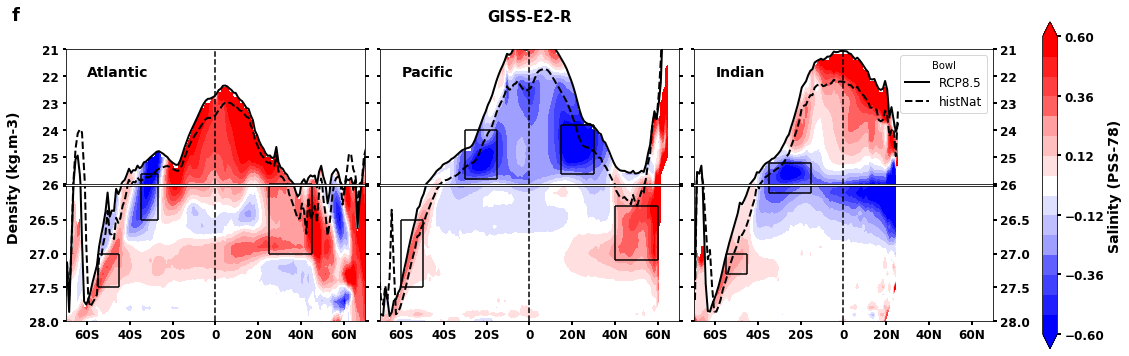

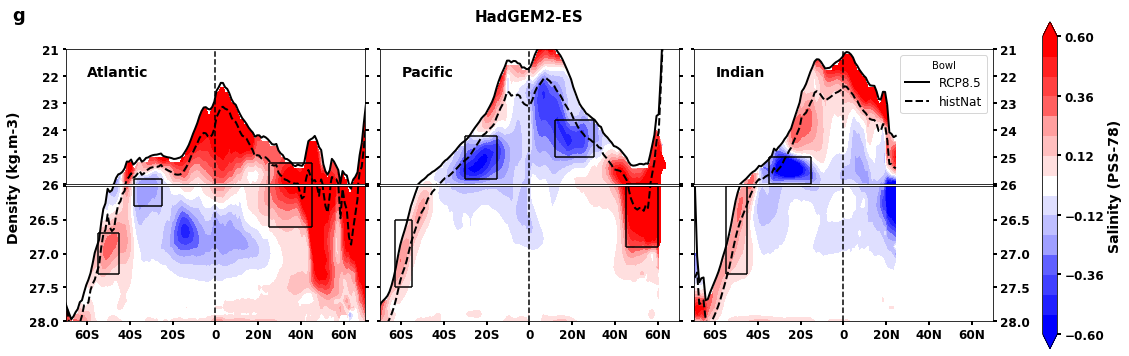

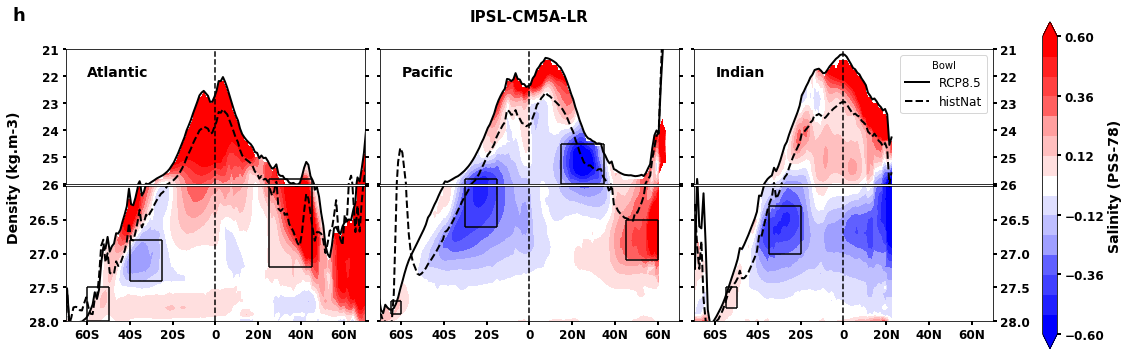

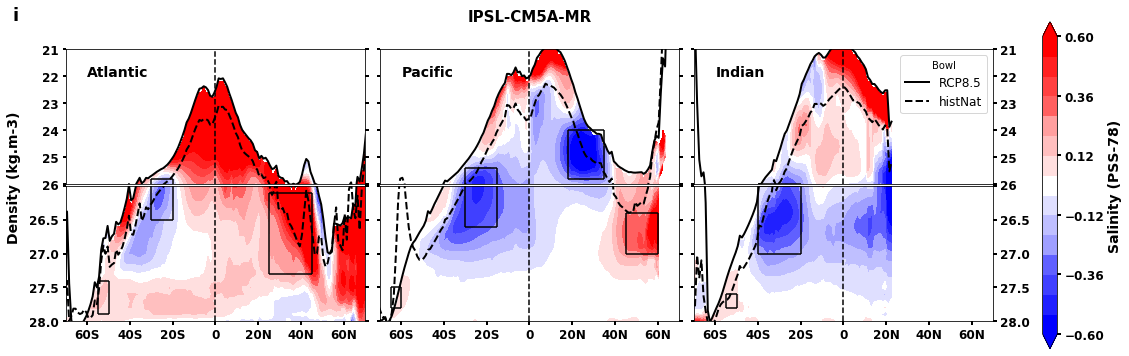

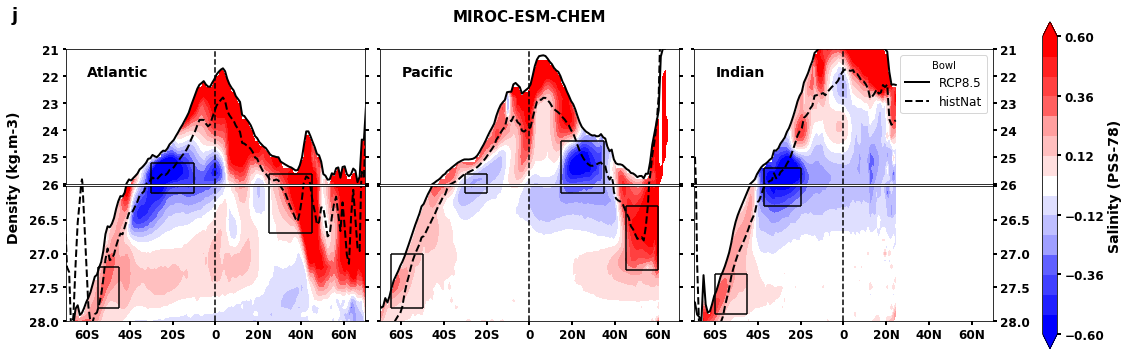

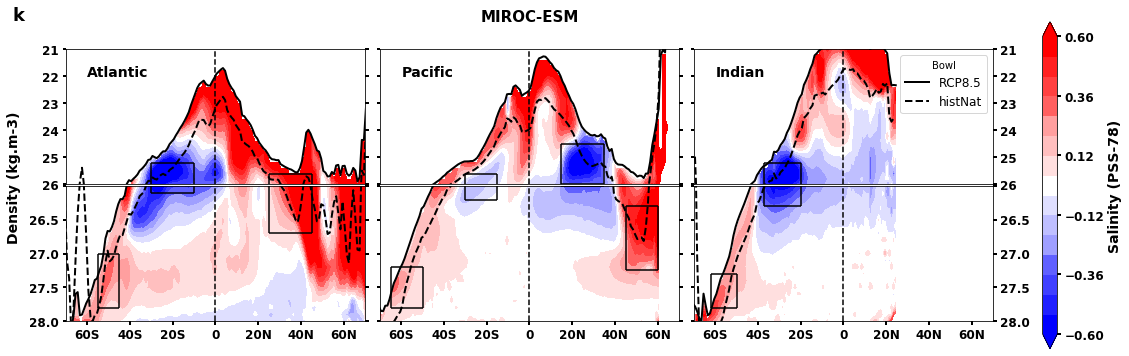

In [2]:
# -- Workspace
indir_rcp85 = '/data/ericglod/Density_binning/Prod_density_april15/mme_rcp85/'
indir_hn = '/data/ericglod/Density_binning/Prod_density_april15/mme_histNat/'

# -- Properties
varname = defVarmme('salinity'); v = 'S'
var = varname['var_zonal_w/bowl']
minmax = varname['minmax_zonal_rcp85']
clevsm = varname['clevsm_zonal']
legVar = varname['legVar']
unit = varname['unit']

# -- Density domain 
rhomin = 21
rhomid = 26
rhomax = 28
domrho = [rhomin, rhomid, rhomax]

# -- Loop on models
models = defModels()
imodel=0
for i, model in enumerate(models):
#i=1
#model = models[i]

    if len(model['hist-rcp85'])!=0:
        print(model['name'])
        # -- Read files
        filercp85_2d = glob.glob(indir_rcp85+'*' + model['name'] + '.' + '*zon2D.nc')[0]
        filercp85_1d = glob.glob(indir_rcp85+'*' + model['name'] + '.' + '*zon1D.nc')[0]
        frcp85_2d = xr.open_dataset(filercp85_2d, decode_times=False)
        frcp85_1d = xr.open_dataset(filercp85_1d, decode_times=False)
        filehn_2d = glob.glob(indir_hn+'*' + model['name'] + '.' + '*zon2D.nc')[0]
        filehn_1d = glob.glob(indir_hn+'*' + model['name'] + '.' + '*zon1D.nc')[0]
        fhn_2d = xr.open_dataset(filehn_2d, decode_times=False)
        fhn_1d = xr.open_dataset(filehn_1d, decode_times=False)

        lat = frcp85_2d.latitude
        density = frcp85_2d.lev
        basin = frcp85_2d.basin

        timercp = np.arange(2006,2101)
        timehn = np.arange(1861,2006)
        fhn_2d['time'] = timehn
        fhn_1d['time'] = timehn
        frcp85_2d['time'] = timercp
        frcp85_1d['time'] = timercp

        var2 = frcp85_2d.isonso.sel(time=slice(2080,2100)).mean(dim='time')
        var1 = fhn_2d.isonso.mean(dim='time')
        var_change = var2 - var1
        bowl2 = frcp85_1d.ptopsigma.sel(time=slice(2080,2100)).mean(dim='time')
        bowl1 = fhn_1d.ptopsigma.mean(dim='time')
        labBowl = ['histNat', 'RCP8.5']

        var_change = var_change.where(bowl2<var_change.lev) # Mask above bowl

        # -- Read region coordinates 
        regions = ['SO_subpolar_atl', 'SO_subpolar_pac', 'SO_subpolar_ind', 'SH_subtropics_atl', 'SH_subtropics_pac', 'SH_subtropics_ind', 'NH_subtropics_atl', 'NH_subtropics_pac', 'subpolar_northpac']
        model_boxes = xr.DataArray(np.zeros((9,4)),dims=['regions','coord'],coords=[regions,['lat1','lat2','rho1','rho2']])
        model_boxes[0] = ToEdomainrcp85vshistNat(model['name'], 'SO')[0]['Atlantic']
        model_boxes[1] = ToEdomainrcp85vshistNat(model['name'], 'SO')[0]['Pacific']
        model_boxes[2] = ToEdomainrcp85vshistNat(model['name'], 'SO')[0]['Indian']
        model_boxes[3] = ToEdomainrcp85vshistNat(model['name'], 'Southern ST')[0]['Atlantic']
        model_boxes[4] = ToEdomainrcp85vshistNat(model['name'], 'Southern ST')[0]['Pacific']
        model_boxes[5] = ToEdomainrcp85vshistNat(model['name'], 'Southern ST')[0]['Indian']
        model_boxes[6] = ToEdomainrcp85vshistNat(model['name'], 'North Atlantic')[0]['Atlantic']
        model_boxes[7] = ToEdomainrcp85vshistNat(model['name'], 'Northern ST')[0]['Pacific']
        model_boxes[8] = ToEdomainrcp85vshistNat(model['name'], 'North Pacific')[0]['Pacific']

        # -- Create variable bundles
        varPac = {'name': 'Pacific', 'var_change': var_change[2,:,:], 'var_mean': None,
                  'bowl1': bowl1[2,:], 'bowl2': bowl2[2,:], 'labBowl': labBowl}
        varAtl = {'name': 'Atlantic', 'var_change': var_change[1,:,:], 'var_mean': None,
                  'bowl1': bowl1[1,:], 'bowl2': bowl2[1,:], 'labBowl': labBowl}
        varInd = {'name': 'Indian', 'var_change': var_change[3,:,:], 'var_mean': None,
                  'bowl1': bowl1[3,:], 'bowl2': bowl2[3,:], 'labBowl': labBowl}

        # -- Plot

        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17,5))

        levels = np.linspace(minmax[0], minmax[1], minmax[2])
        cmap = custom_div_cmap() 

        cnplot = zonal_2D(plt, 'total_mme', axes[0, 0], axes[1, 0], 'left', var_change.latitude, var_change.lev, varAtl, domrho, cmap, levels, clevsm)
        cnplot = zonal_2D(plt, 'total_mme', axes[0, 1], axes[1, 1], 'mid', var_change.latitude, var_change.lev, varPac, domrho, cmap, levels, clevsm)
        cnplot = zonal_2D(plt, 'total_mme', axes[0, 2], axes[1, 2], 'right', var_change.latitude, var_change.lev, varInd, domrho, cmap, levels, clevsm)

        for ax in axes.ravel().tolist():
            ax.tick_params(axis='both', which='major', labelsize=12)

        # -- Plot boxes    
        for i in range(3):
            # Southern Ocean subpolar
            axes[1,i].hlines(y=(model_boxes[i][2],model_boxes[i][3]),xmin=model_boxes[i][0],xmax=model_boxes[i][1])
            axes[1,i].vlines(x=(model_boxes[i][0],model_boxes[i][1]),ymin=model_boxes[i][2],ymax=model_boxes[i][3])
            # SH subtropics
            for j in range(2):
                axes[j,i].hlines(y=(model_boxes[i+3][2],model_boxes[i+3][3]),xmin=model_boxes[i+3][0],xmax=model_boxes[i+3][1])
                axes[j,i].vlines(x=(model_boxes[i+3][0],model_boxes[i+3][1]),ymin=model_boxes[i+3][2],ymax=model_boxes[i+3][3])
        # NH subtropics atlantic
        for i in range(2):
            axes[i,0].hlines(y=(model_boxes[6][2],model_boxes[6][3]),xmin=model_boxes[6][0],xmax=model_boxes[6][1])
            axes[i,0].vlines(x=(model_boxes[6][0],model_boxes[6][1]),ymin=model_boxes[6][2],ymax=model_boxes[6][3])
        # NH subtropics pacific
        for i in range(2):
            axes[i,1].hlines(y=(model_boxes[7][2],model_boxes[7][3]),xmin=model_boxes[7][0],xmax=model_boxes[7][1])
            axes[i,1].vlines(x=(model_boxes[7][0],model_boxes[7][1]),ymin=model_boxes[7][2],ymax=model_boxes[7][3])
        # Subpolar north pacific
        for i in range(2):
            axes[i,1].hlines(y=(model_boxes[8][2],model_boxes[8][3]),xmin=model_boxes[8][0],xmax=model_boxes[8][1])
            axes[i,1].vlines(x=(model_boxes[8][0],model_boxes[8][1]),ymin=model_boxes[8][2],ymax=model_boxes[8][3])

        plt.subplots_adjust(hspace=.012, wspace=0.05, left=0.05, right=0.86)

        cb = plt.colorbar(cnplot[0], ax=axes.ravel().tolist(), ticks=levels[::3], fraction=0.015, shrink=2.0, pad=0.05)
        cb.set_label('%s (%s)' % (legVar, unit), fontweight='bold',fontsize=14)
        cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontweight='bold')
        cb.ax.yaxis.set_tick_params(which='major',width=2, labelsize=12)

        plotTitle = model['name']
        plotName = 'supp_'+model['name']+'_RCP85vshistNat'

        plt.figtext(.006,.96,letters[imodel],fontweight='bold',fontsize=18)

        axes[0,1].set_title(plotTitle, y=1.25, fontweight='bold', fontsize=15, verticalalignment='top')
        plt.figtext(.002,.35,'Density (kg.m-3)',rotation='vertical',horizontalalignment='left',fontweight='bold',fontsize=14)

        plt.savefig(plotName+'.png', bbox_inches='tight', dpi=150)

        imodel = imodel+1